In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('datasets/musical_instruments_reviews/Musical_instruments_reviews.csv')

In [3]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [5]:
data.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


### Tidying up feats

In [6]:
data.drop(['reviewerID', 'reviewerName', 'helpful'], axis=1, inplace=True)

In [7]:
data = data.rename(columns={'asin':'product_id', 'overall':'rating', 'unixReviewTime': 'unix_time'})

In [8]:
data.dropna(inplace=True, axis=0)

In [9]:
mv_cols = (data.isnull().sum())
print(mv_cols[mv_cols > 0])

Series([], dtype: int64)


### Creating extra feats

In [10]:
def sentiment(rating):
    if(rating == 1 or rating == 2 or rating == 3):
        return 0
    else:
        return 1

def length(text):
    return len(text)

In [11]:
data['review'] = data['reviewText'] + ' ' + data['summary']

In [12]:
data['reviewTime'] = pd.to_datetime(data['reviewTime'])
data['year'] = data['reviewTime'].dt.year

In [13]:
data['sentiment'] = data['rating'].apply(sentiment)

In [14]:
data['length'] = data['review'].apply(length)

In [15]:
data.drop(['reviewText', 'summary', 'reviewTime'], inplace=True, axis=1)

In [16]:
data.head()

,product_id,rating,unix_time,review,year,sentiment,length
0,1384719342,5.0,1393545600,"Not much to write about here, but it does exac...",2014,1,273
1,1384719342,5.0,1363392000,The product does exactly as it should and is q...,2013,1,549
2,1384719342,5.0,1377648000,The primary job of this device is to block the...,2013,1,457
3,1384719342,5.0,1392336000,Nice windscreen protects my MXL mic and preven...,2014,1,236
4,1384719342,5.0,1392940800,This pop filter is great. It looks and perform...,2014,1,197


### Some Viz

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

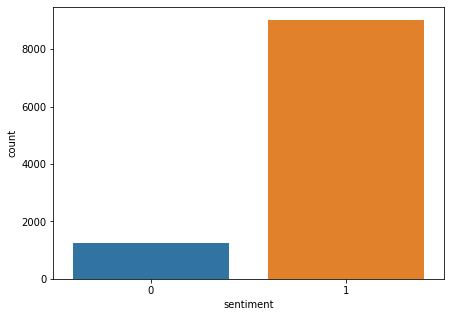

In [18]:
plt.figure(figsize=(7, 5))
sns.countplot(data['sentiment'])
plt.show()
##### Imbalanced classes! :-/

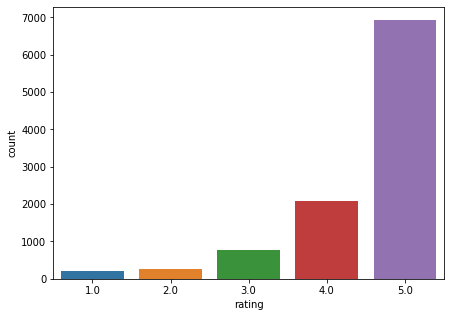

In [19]:
plt.figure(figsize=(7, 5))
sns.countplot(data['rating'])
plt.show()

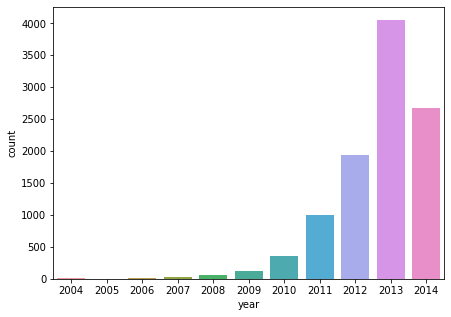

In [20]:
plt.figure(figsize=(7, 5))
sns.countplot(data['year'])
plt.show()

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
cv = CountVectorizer(stop_words='english')

In [23]:
words = cv.fit_transform(data['review'])

In [24]:
type(words)

scipy.sparse.csr.csr_matrix

In [25]:
words.shape

(10254, 20634)

In [26]:
data.shape

(10254, 7)

In [27]:
sum_words = words.sum(axis=0) # sum through cols

In [28]:
sum_words.shape

(1, 20634)

In [29]:
type(cv.vocabulary_)

dict

In [30]:
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

In [31]:
frequency = pd.DataFrame(words_freq, columns=['word','freq'])

In [32]:
frequency.head()

,word,freq
0,guitar,6165
1,great,6044
2,good,4996
3,like,4149
4,use,3976


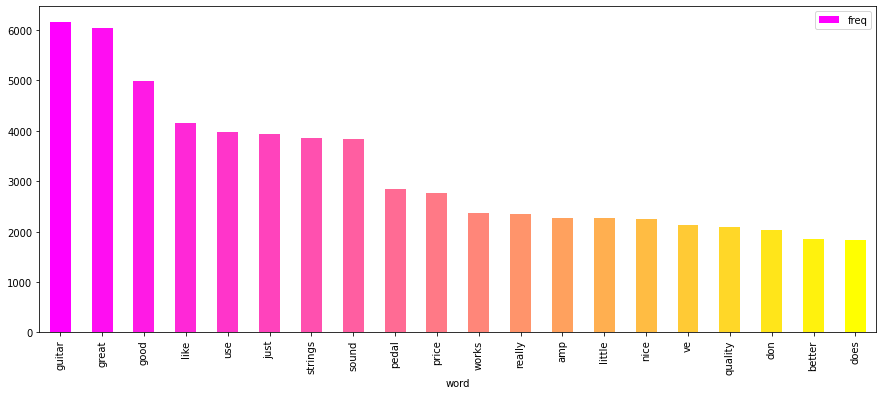

In [33]:
color = plt.cm.spring(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color=color)
plt.show()

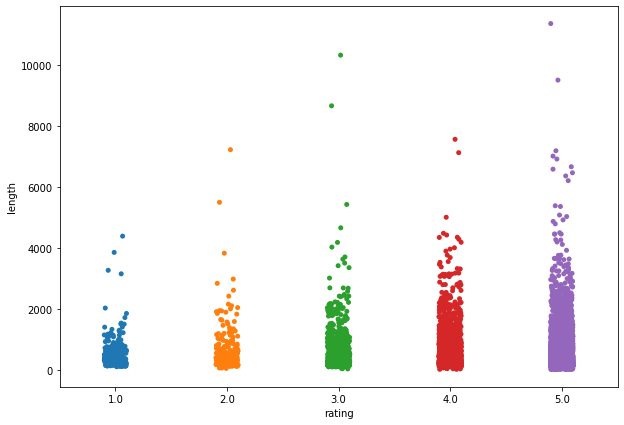

In [34]:
plt.figure(figsize=(10, 7))
sns.stripplot(x='rating', y='length', data=data)
plt.show()

In [35]:
x = pd.crosstab(data['year'], data['rating'])

In [36]:
x

rating,1.0,2.0,3.0,4.0,5.0
year,,,,,
2004,0,0,0,1,6
2005,0,0,0,1,3
2006,1,0,1,2,6
2007,0,1,0,5,16
2008,0,2,7,18,36
2009,3,2,8,29,85
2010,7,9,20,83,231
2011,15,31,84,195,681
2012,46,39,130,378,1340


<Figure size 1080x648 with 0 Axes>

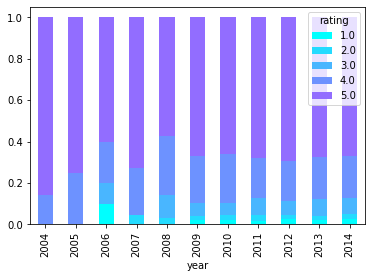

In [37]:
plt.figure(figsize=(15, 9))
color = plt.cm.cool(np.linspace(0, 1, 8))
x.div(x.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=color)
plt.show()

### Data prepro

In [38]:
data.drop(['unix_time','year','length','rating','product_id'], axis=1, inplace=True)

In [39]:
data.head()

,review,sentiment
0,"Not much to write about here, but it does exac...",1
1,The product does exactly as it should and is q...,1
2,The primary job of this device is to block the...,1
3,Nice windscreen protects my MXL mic and preven...,1
4,This pop filter is great. It looks and perform...,1


In [40]:
from nltk.corpus import stopwords
import re, string, unicodedata

In [41]:
# setting up stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)

In [42]:
# add punctuation as stop word
stop.update(punctuation)

In [43]:
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [44]:
# function to return type of word
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# lemmatizing words that arent stopwords
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(), get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)

In [45]:
data.head()

,review,sentiment
0,"Not much to write about here, but it does exac...",1
1,The product does exactly as it should and is q...,1
2,The primary job of this device is to block the...,1
3,Nice windscreen protects my MXL mic and preven...,1
4,This pop filter is great. It looks and perform...,1


In [46]:
data['review'] = data['review'].apply(lemmatize_words)

In [47]:
data.head()

,review,sentiment
0,"much write here, exactly suppose to. filter po...",1
1,product exactly quite affordable.i realize dou...,1
2,primary job device block breath would otherwis...,1
3,nice windscreen protects mxl mic prevents pops...,1
4,pop filter great. look performs like studio fi...,1


### Modelling

In [48]:
X = data['review']
y = data['sentiment']

In [49]:
# bag of words encoding:
cv = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

cv_train_reviews = cv.fit_transform(X)
# but we're not gonna use them! :P

In [50]:
# we'll use TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
## converts a collection of raw docs to a matrix of TF-IDF feats

In [51]:
tf = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1, 2))
X = tf.fit_transform(X)

In [52]:
type(X)

scipy.sparse.csr.csr_matrix

In [53]:
X.shape

(10254, 244342)

In [54]:
data['review'].shape

(10254,)

### Using SMOTE for imbalanced classes

In [55]:
from imblearn.combine import SMOTETomek

In [56]:
smk = SMOTETomek(random_state=42, sampling_strategy=0.8)

In [57]:
X, y = smk.fit_sample(X, y)

In [58]:
X.shape

(16227, 244342)

### Modelling

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
modelMN = MultinomialNB()
modelMN.fit(X_train, y_train)
preds = modelMN.predict(X_test)
acc = accuracy_score(y_test, preds)
print('Acc:', acc)

Acc: 0.9571780653111522


In [64]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1478
           1       0.93      1.00      0.96      1768

    accuracy                           0.96      3246
   macro avg       0.96      0.95      0.96      3246
weighted avg       0.96      0.96      0.96      3246

[[1339  139]
 [   0 1768]]
